# Mortality prediction post micro-biology result patients using EHR data with QC (only missing data imputation) - XGBoost

## Read data matrix

In [1]:
import pandas as pd
import psycopg2

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'sepsis_micro'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

dataQuery = """select * from sepsis_micro.data_matrix_qc_1;"""
dataDf = pd.read_sql_query(dataQuery, con)
dataDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,...,bicarbonate_first,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last
0,9769904,-1046091425,0,0,0,0,0,0,0,0,...,0.232437,0.672591,-0.826453,-0.056485,-0.213440,-0.772442,-0.615576,0.046775,0.382481,-0.710177
1,2985612,697543230,0,0,0,0,0,0,0,0,...,-0.905166,-1.303816,-0.686594,-1.608937,1.859297,-0.344966,1.088720,-0.718203,0.323023,-0.496477
2,2871076,428913244,0,0,0,0,0,0,0,0,...,0.232437,-0.391629,-0.686594,-0.746464,1.119034,-0.772442,0.899354,0.429265,2.701327,-0.638943
3,6894504,-1600246244,0,0,0,0,1,1,1,0,...,-0.146764,0.723268,-0.756523,0.978483,-0.657598,-0.307794,-0.236844,0.429265,1.095972,-0.781410
4,8752252,431197671,1,1,1,1,1,1,1,0,...,1.370041,-0.695691,-0.406877,-0.573969,0.526823,-0.995473,0.331255,0.238020,-0.509383,-0.710177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,1866973,2023686478,0,0,0,0,0,0,0,0,...,-1.094767,-0.645014,1.061635,-1.091453,1.711244,-0.177693,1.088720,-0.909448,-0.509383,-0.069076
7335,2124103,2023686478,0,0,0,0,0,0,0,0,...,0.422038,0.368528,-0.966311,-0.918959,0.526823,-0.475067,-0.047477,-0.144469,0.382481,-0.923877
7336,5256383,2023686478,0,0,0,0,0,0,0,0,...,-1.094767,0.925976,0.711990,0.978483,-0.805651,-0.921129,-0.426210,0.238020,0.441938,0.073391
7337,2268946,1484033855,0,0,0,0,0,0,0,0,...,0.801239,-0.391629,-0.826453,-0.401475,0.822928,-0.456481,0.709987,1.385488,-0.212095,-0.638943


## Test/Train split

In [2]:
X = dataDf.drop(['micro_specimen_id', 'person_id', 'seven_day_mortality', 'fourteen_day_mortality', 'twentyone_day_mortality', 'twentyeight_day_mortality', 'sixty_day_mortality', 'ninety_day_mortality', 'onetwenty_day_mortality'], axis = 1)
y_seven_day = dataDf['seven_day_mortality']
y_fourteen_day = dataDf['fourteen_day_mortality']
y_twentyone_day = dataDf['twentyone_day_mortality']
y_twentyeight_day = dataDf['twentyeight_day_mortality']
y_sixty_day = dataDf['sixty_day_mortality']
y_ninety_day = dataDf['ninety_day_mortality']
y_onetwenty_day = dataDf['onetwenty_day_mortality']

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_seven_day_train, y_seven_day_test, y_fourteen_day_train, y_fourteen_day_test, y_twentyone_day_train, y_twentyone_day_test, y_twentyeight_day_train, y_twentyeight_day_test, y_sixty_day_train, y_sixty_day_test, y_ninety_day_train, y_ninety_day_test, y_onetwenty_day_train, y_onetwenty_day_test = train_test_split(X, y_seven_day, y_fourteen_day, y_twentyone_day, y_twentyeight_day, y_sixty_day, y_ninety_day, y_onetwenty_day, test_size=0.2, random_state=42)

In [4]:
X_train.shape, X_test.shape

((5871, 158), (1468, 158))

In [5]:
y_seven_day_train.shape, y_seven_day_test.shape

((5871,), (1468,))

In [6]:
y_fourteen_day_train.shape, y_fourteen_day_test.shape

((5871,), (1468,))

In [7]:
y_twentyone_day_train.shape, y_twentyone_day_test.shape

((5871,), (1468,))

In [8]:
y_twentyeight_day_train.shape, y_twentyeight_day_test.shape

((5871,), (1468,))

In [9]:
y_sixty_day_train.shape, y_sixty_day_test.shape

((5871,), (1468,))

In [10]:
y_ninety_day_train.shape, y_ninety_day_test.shape

((5871,), (1468,))

In [11]:
y_onetwenty_day_train.shape, y_onetwenty_day_test.shape

((5871,), (1468,))

## Machine Learning using XGBoost

In [12]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

### Seven-day mortality prediction

In [13]:
xgb_seven_day = XGBClassifier()
xgb_seven_day.fit(X_train, y_seven_day_train)
y_seven_day_pred = xgb_seven_day.predict(X_test)
y_seven_day_prob = xgb_seven_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:50:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 141 artists>

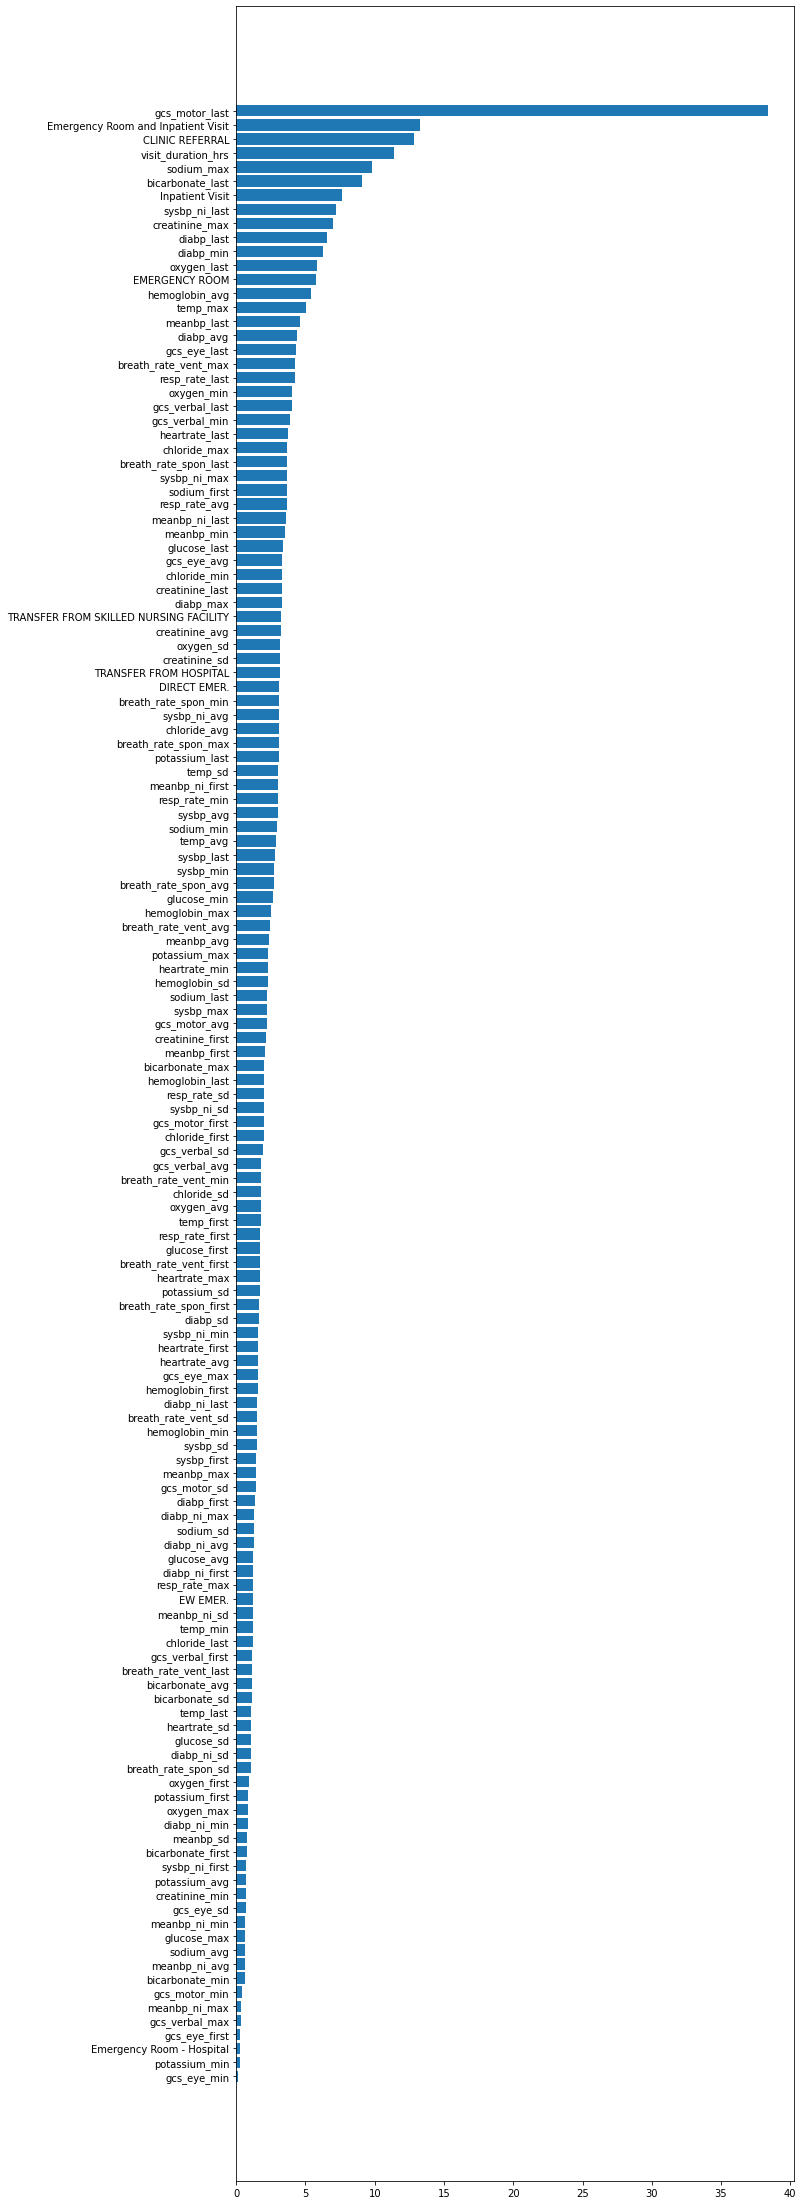

In [14]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_seven_day.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Fourteen-day mortality prediction

In [15]:
xgb_fourteen_day = XGBClassifier()
xgb_fourteen_day.fit(X_train, y_fourteen_day_train)
y_fourteen_day_pred = xgb_fourteen_day.predict(X_test)
y_fourteen_day_prob = xgb_fourteen_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:50:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 143 artists>

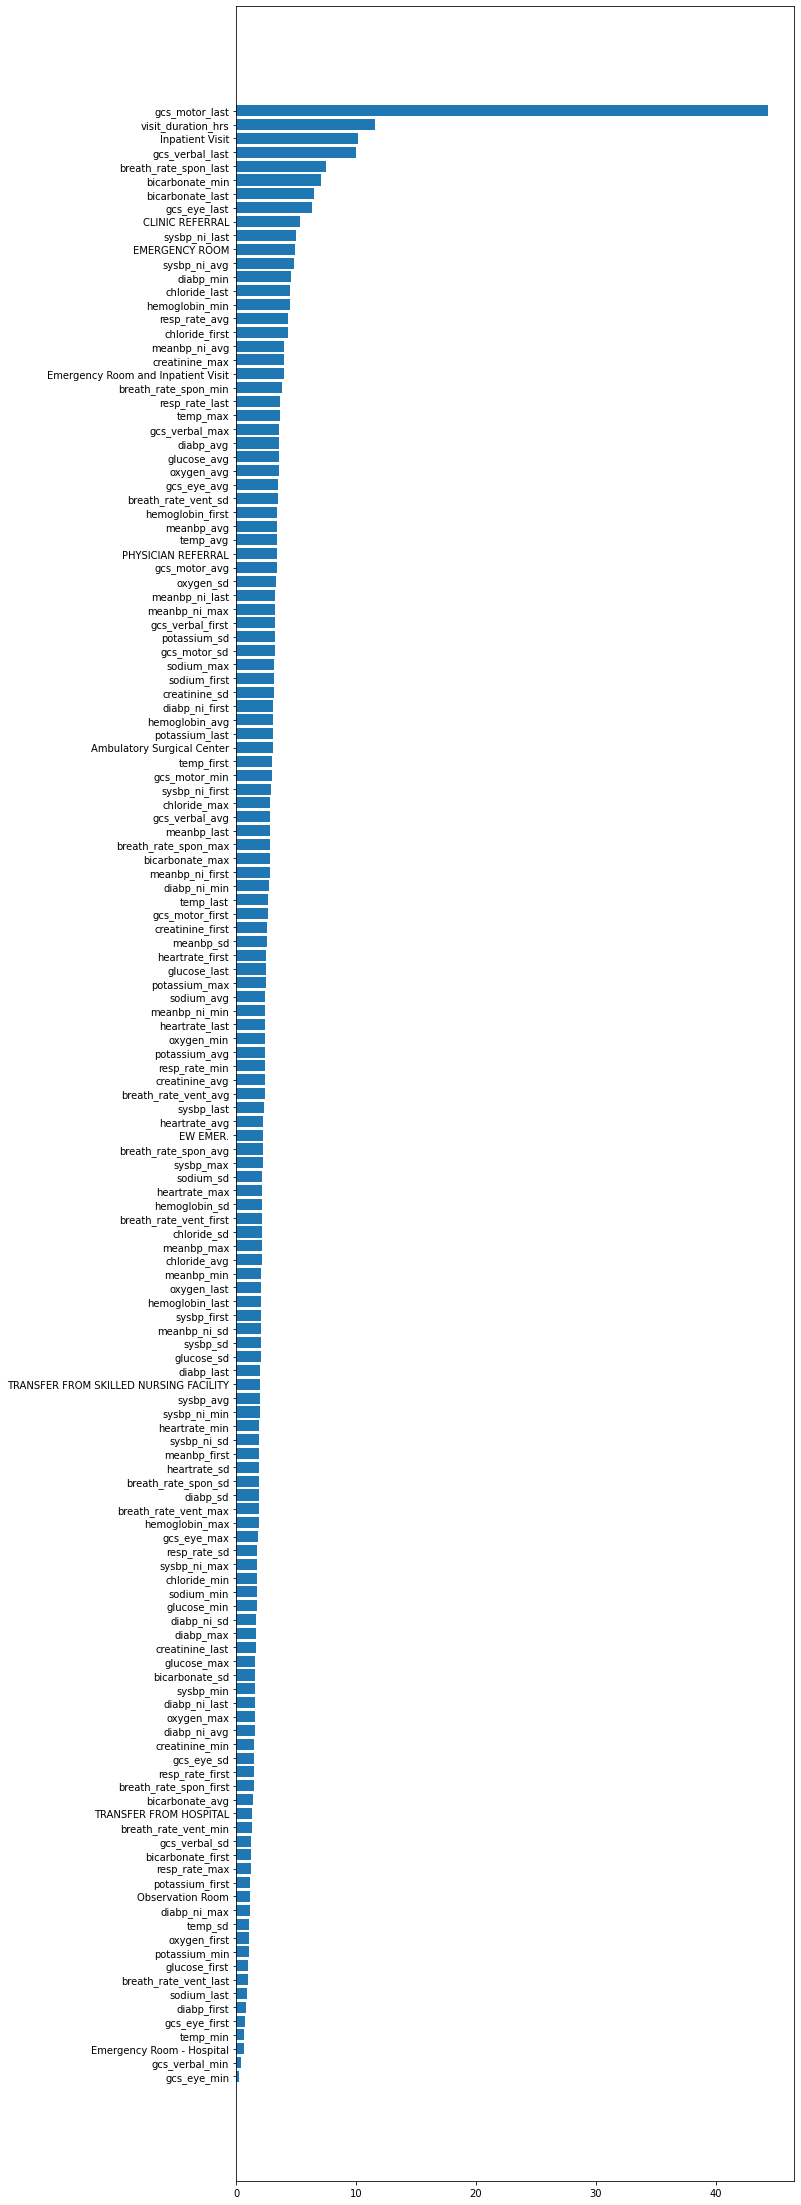

In [16]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_fourteen_day.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Twentyone-day mortality prediction

In [17]:
xgb_twentyone_day = XGBClassifier()
xgb_twentyone_day.fit(X_train, y_twentyone_day_train)
y_twentyone_day_pred = xgb_twentyone_day.predict(X_test)
y_twentyone_day_prob = xgb_twentyone_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:52:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 142 artists>

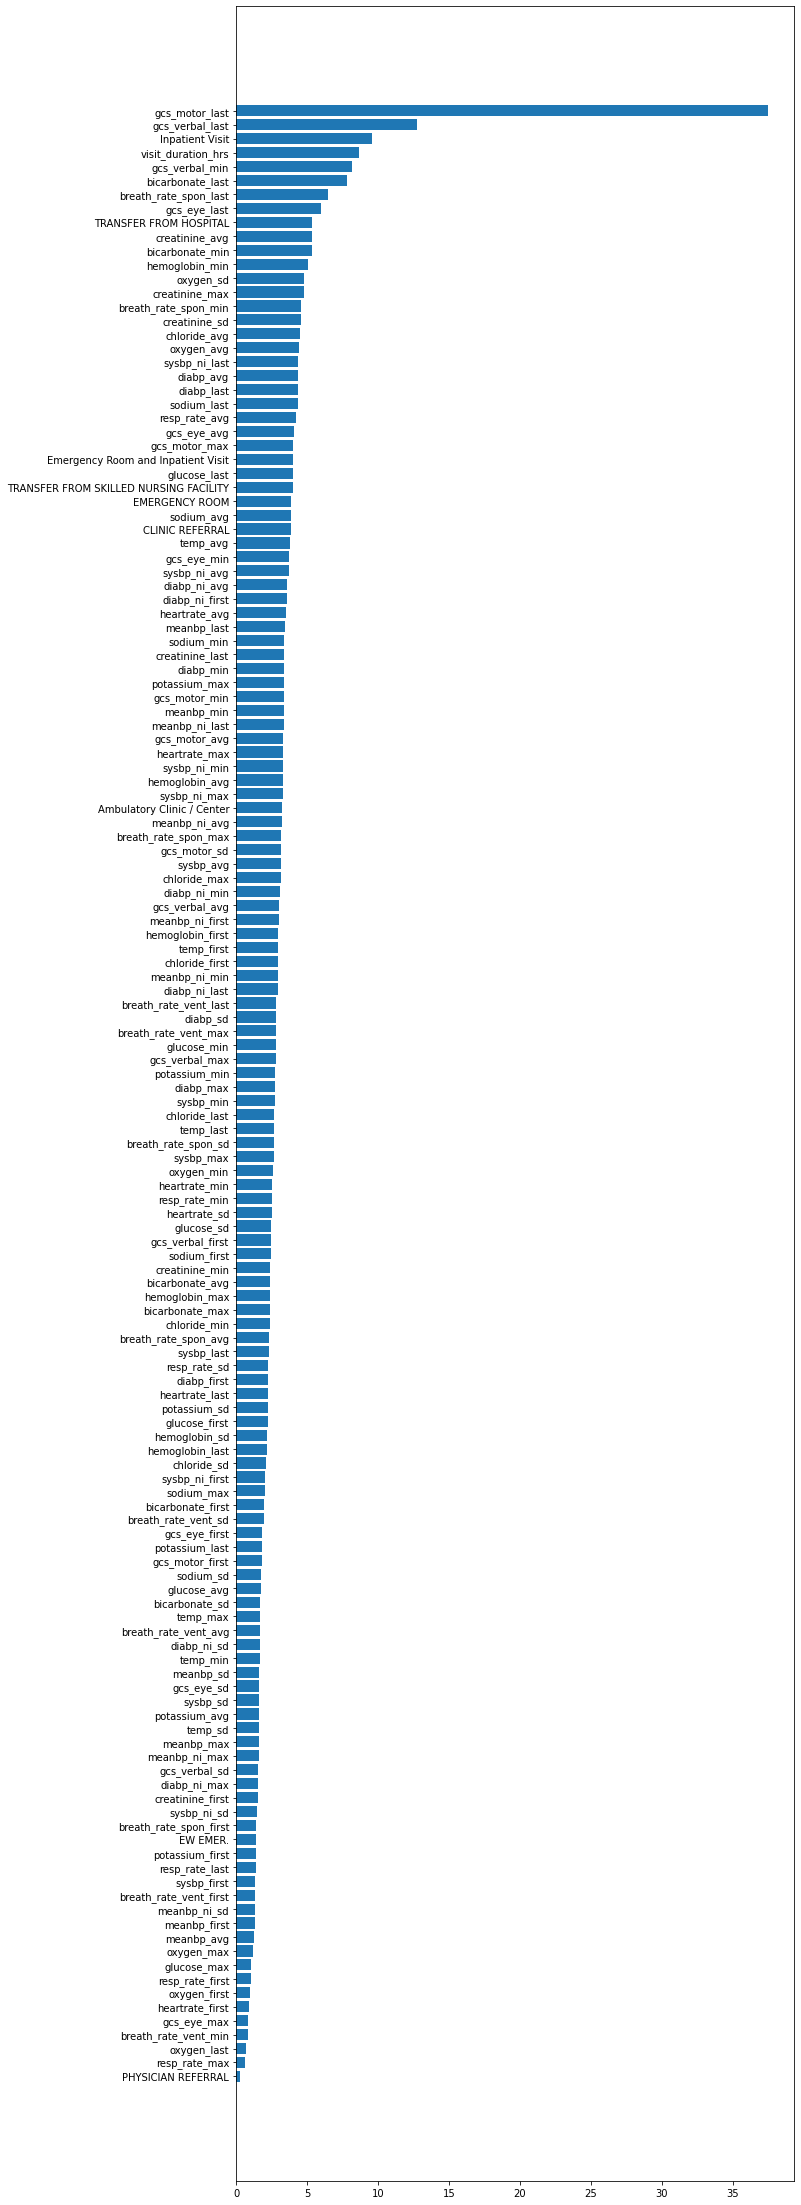

In [18]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_twentyone_day.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Twentyeight-day mortality prediction

In [19]:
xgb_twentyeight_day = XGBClassifier()
xgb_twentyeight_day.fit(X_train, y_twentyeight_day_train)
y_twentyeight_day_pred = xgb_twentyeight_day.predict(X_test)
y_twentyeight_day_prob = xgb_twentyeight_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:54:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 143 artists>

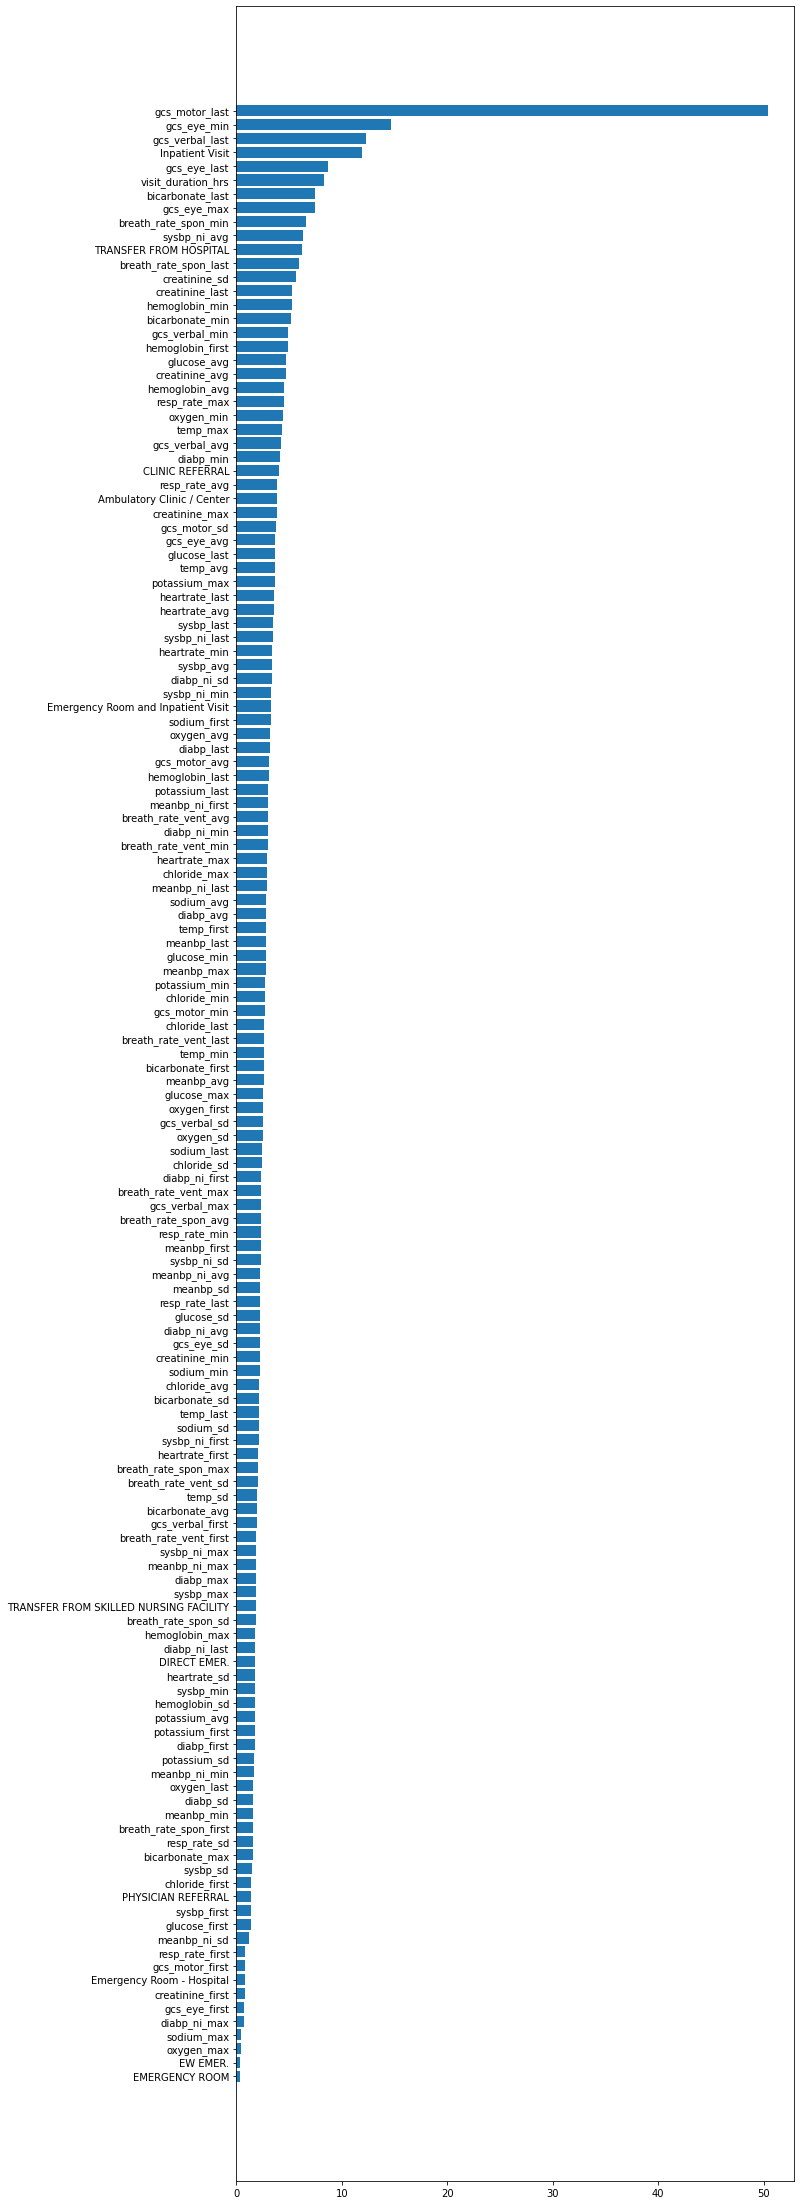

In [20]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_twentyeight_day.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Sixty-day mortality prediction

In [21]:
xgb_sixty_day = XGBClassifier()
xgb_sixty_day.fit(X_train, y_sixty_day_train)
y_sixty_day_pred = xgb_sixty_day.predict(X_test)
y_sixty_day_prob = xgb_sixty_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:56:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 145 artists>

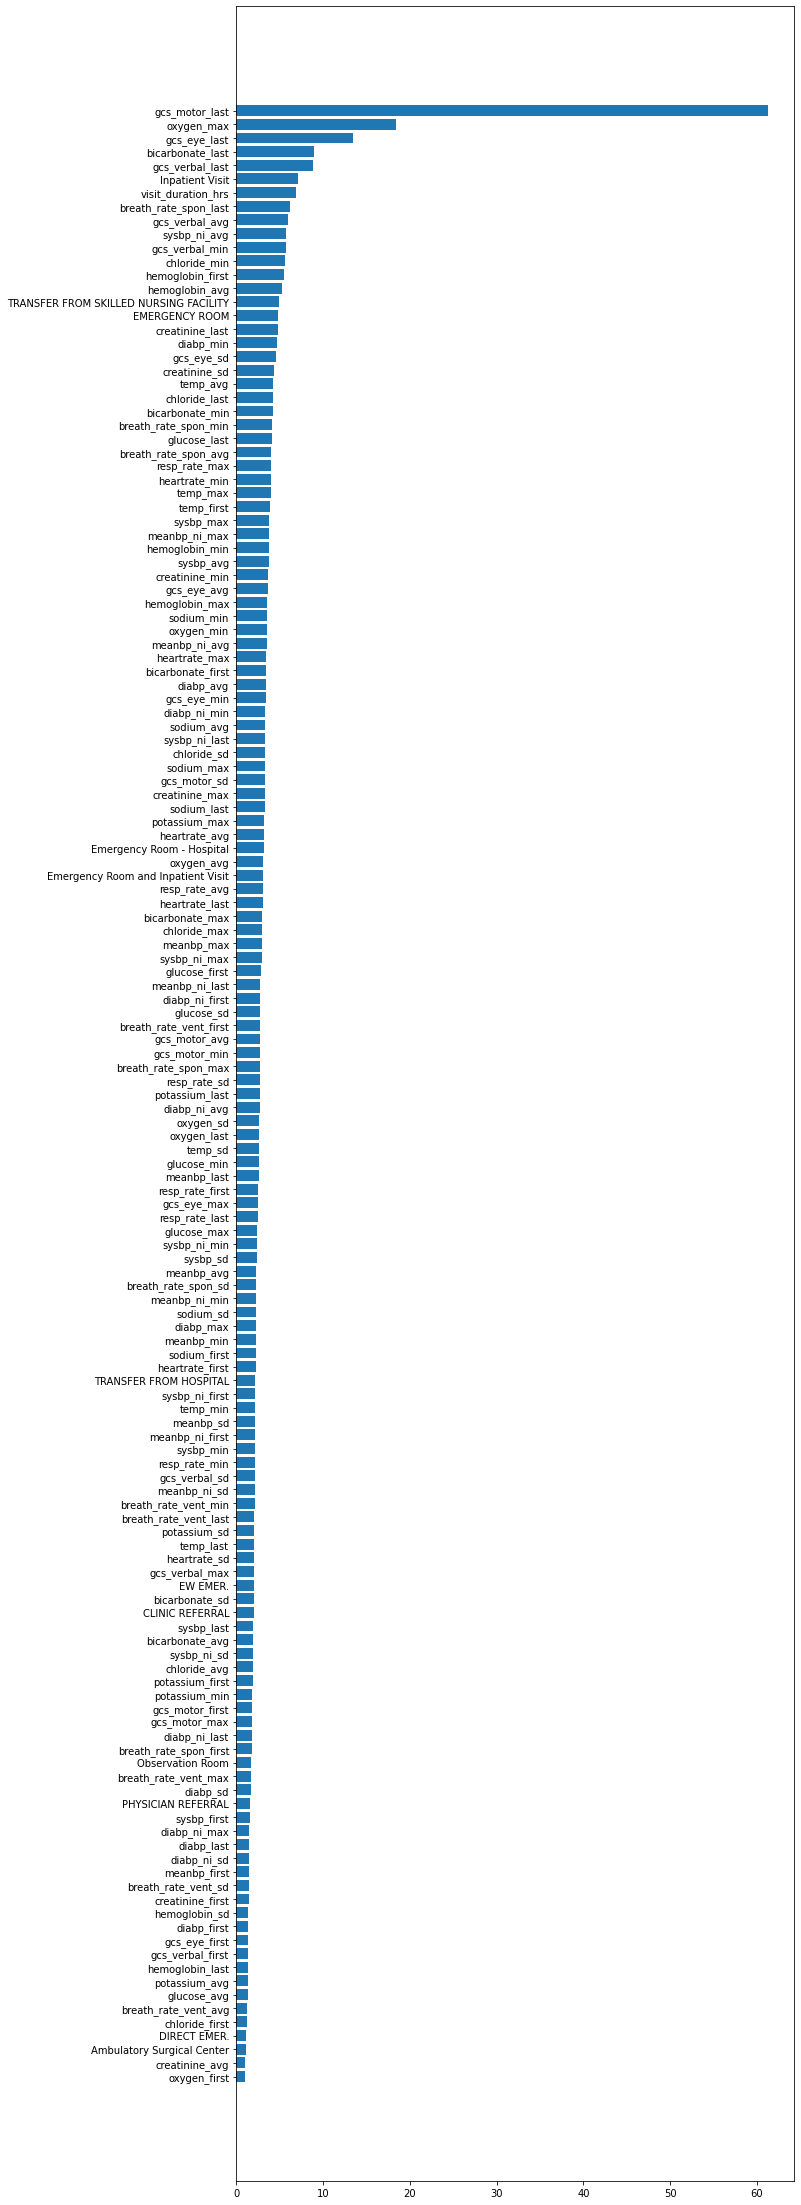

In [22]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_sixty_day.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Ninety-day mortality prediction

In [23]:
xgb_ninety_day = XGBClassifier()
xgb_ninety_day.fit(X_train, y_ninety_day_train)
y_ninety_day_pred = xgb_ninety_day.predict(X_test)
y_ninety_day_prob = xgb_ninety_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:58:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 144 artists>

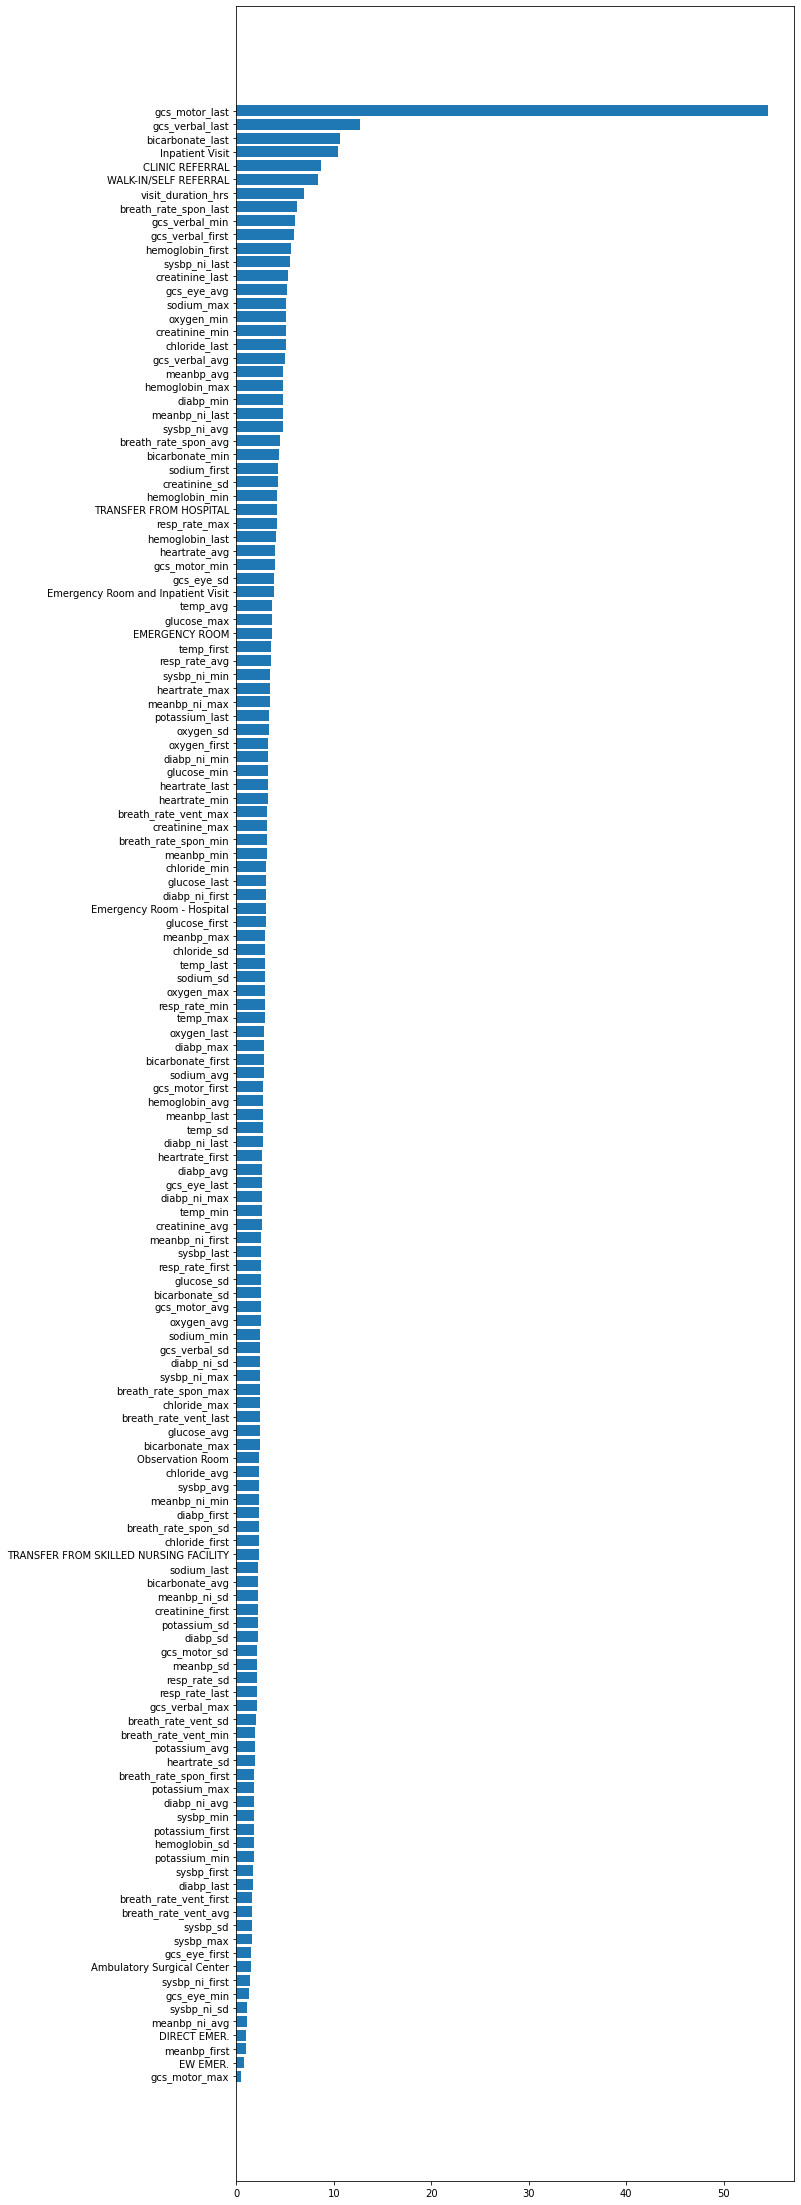

In [24]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_ninety_day.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Onetwenty-day mortality prediction

In [25]:
xgb_onetwenty_day = XGBClassifier()
xgb_onetwenty_day.fit(X_train, y_onetwenty_day_train)
y_onetwenty_day_pred = xgb_onetwenty_day.predict(X_test)
y_onetwenty_day_prob = xgb_onetwenty_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 147 artists>

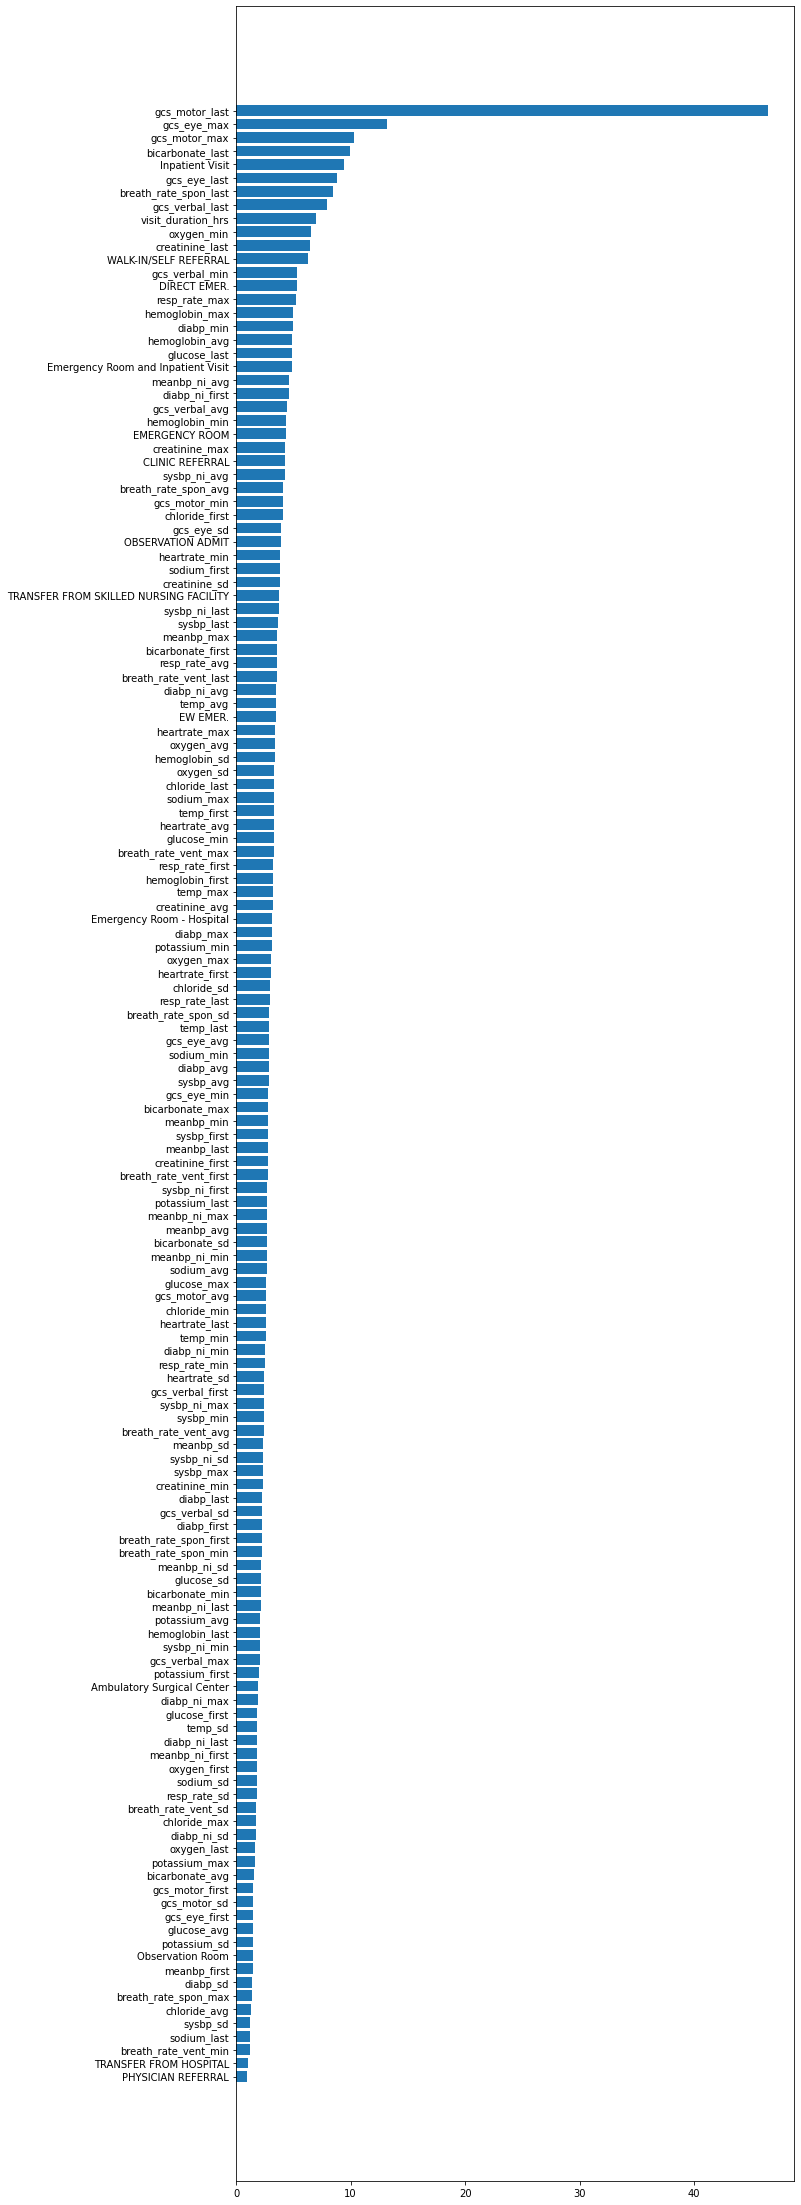

In [26]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_onetwenty_day.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Performance metrics

#### Accuracy

In [27]:
from sklearn.metrics import accuracy_score

print('Seven day mortality accuracy: ', str(accuracy_score(y_seven_day_pred, y_seven_day_test)))
print('Fourteen day mortality accuracy: ', str(accuracy_score(y_fourteen_day_pred, y_fourteen_day_test)))
print('Twentyone day mortality accuracy: ', str(accuracy_score(y_twentyone_day_pred, y_twentyone_day_test)))
print('Twentyeight day mortality accuracy: ', str(accuracy_score(y_twentyeight_day_pred, y_twentyeight_day_test)))
print('Sixty day mortality accuracy: ', str(accuracy_score(y_sixty_day_pred, y_sixty_day_test)))
print('Ninety day mortality accuracy: ', str(accuracy_score(y_ninety_day_pred, y_ninety_day_test)))
print('Onetwenty day mortality accuracy: ', str(accuracy_score(y_onetwenty_day_pred, y_onetwenty_day_test)))

Seven day mortality accuracy:  0.967983651226158
Fourteen day mortality accuracy:  0.9482288828337875
Twentyone day mortality accuracy:  0.9352861035422343
Twentyeight day mortality accuracy:  0.9230245231607629
Sixty day mortality accuracy:  0.9209809264305178
Ninety day mortality accuracy:  0.9155313351498637
Onetwenty day mortality accuracy:  0.9025885558583107


#### F1 score

In [28]:
from sklearn.metrics import f1_score

print('Seven day mortality F1: ', str(f1_score(y_seven_day_pred, y_seven_day_test)))
print('Fourteen day mortality F1: ', str(f1_score(y_fourteen_day_pred, y_fourteen_day_test)))
print('Twentyone day mortality F1: ', str(f1_score(y_twentyone_day_pred, y_twentyone_day_test)))
print('Twentyeight day mortality F1: ', str(f1_score(y_twentyeight_day_pred, y_twentyeight_day_test)))
print('Sixty day mortality F1: ', str(f1_score(y_sixty_day_pred, y_sixty_day_test)))
print('Ninety day mortality F1: ', str(f1_score(y_ninety_day_pred, y_ninety_day_test)))
print('Onetwenty day mortality F1: ', str(f1_score(y_onetwenty_day_pred, y_onetwenty_day_test)))

Seven day mortality F1:  0.8827930174563592
Fourteen day mortality F1:  0.8661971830985916
Twentyone day mortality F1:  0.8494453248811411
Twentyeight day mortality F1:  0.8295625942684767
Sixty day mortality F1:  0.8457446808510638
Ninety day mortality F1:  0.8402061855670103
Onetwenty day mortality F1:  0.8205771643663738


#### Matthews Correlation Coefficient

In [29]:
from sklearn.metrics import matthews_corrcoef

print('Seven day mortality F1: ', str(matthews_corrcoef(y_seven_day_pred, y_seven_day_test)))
print('Fourteen day mortality F1: ', str(matthews_corrcoef(y_fourteen_day_pred, y_fourteen_day_test)))
print('Twentyone day mortality F1: ', str(matthews_corrcoef(y_twentyone_day_pred, y_twentyone_day_test)))
print('Twentyeight day mortality F1: ', str(matthews_corrcoef(y_twentyeight_day_pred, y_twentyeight_day_test)))
print('Sixty day mortality F1: ', str(matthews_corrcoef(y_sixty_day_pred, y_sixty_day_test)))
print('Ninety day mortality F1: ', str(matthews_corrcoef(y_ninety_day_pred, y_ninety_day_test)))
print('Onetwenty day mortality F1: ', str(matthews_corrcoef(y_onetwenty_day_pred, y_onetwenty_day_test)))

Seven day mortality F1:  0.8694003172035962
Fourteen day mortality F1:  0.8398415049698693
Twentyone day mortality F1:  0.8162744323480833
Twentyeight day mortality F1:  0.7906232498553114
Sixty day mortality F1:  0.7998951175378269
Ninety day mortality F1:  0.7909475182557562
Onetwenty day mortality F1:  0.763352848840572


In [30]:
from sklearn.metrics import roc_auc_score

print('Seven day mortality F1: ', str(roc_auc_score(y_seven_day_pred, y_seven_day_test)))
print('Fourteen day mortality F1: ', str(roc_auc_score(y_fourteen_day_pred, y_fourteen_day_test)))
print('Twentyone day mortality F1: ', str(roc_auc_score(y_twentyone_day_pred, y_twentyone_day_test)))
print('Twentyeight day mortality F1: ', str(roc_auc_score(y_twentyeight_day_pred, y_twentyeight_day_test)))
print('Sixty day mortality F1: ', str(roc_auc_score(y_sixty_day_pred, y_sixty_day_test)))
print('Ninety day mortality F1: ', str(roc_auc_score(y_ninety_day_pred, y_ninety_day_test)))
print('Onetwenty day mortality F1: ', str(roc_auc_score(y_onetwenty_day_pred, y_onetwenty_day_test)))

Seven day mortality F1:  0.9699340317536275
Fourteen day mortality F1:  0.9502979050547761
Twentyone day mortality F1:  0.9410289069881478
Twentyeight day mortality F1:  0.9313021339709844
Sixty day mortality F1:  0.9259803921568627
Ninety day mortality F1:  0.9219191306195922
Onetwenty day mortality F1:  0.9089012059780064


#### Confusion matrix

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10), title='Confusion Matrix for the classifier'):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.title(title)
    plt.show()

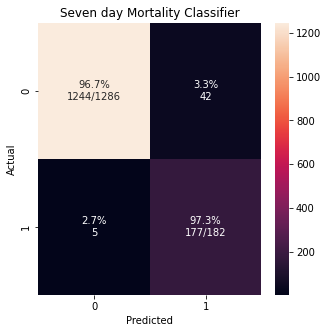

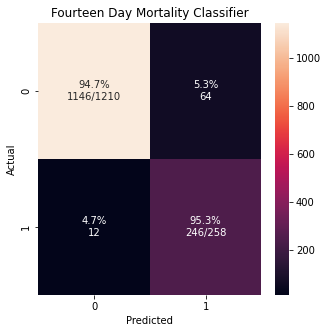

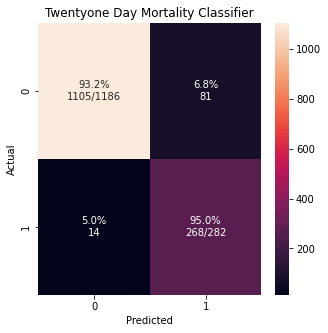

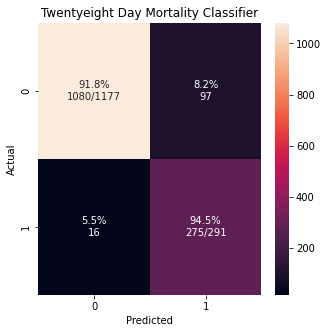

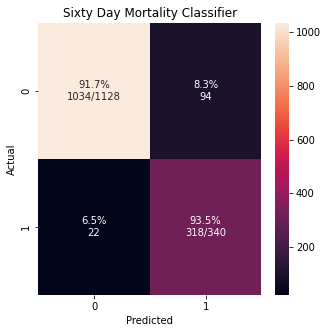

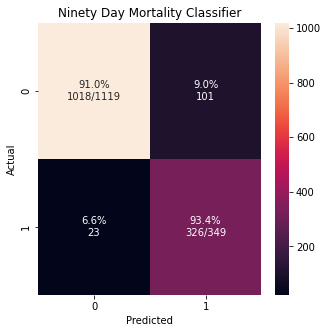

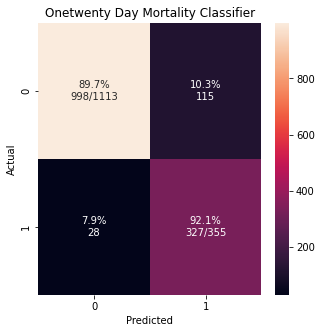

In [32]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(y_seven_day_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven day Mortality Classifier')

cm_analysis(y_fourteen_day_pred, y_fourteen_day_test, labels, ymap=None, figsize=(5, 5), title='Fourteen Day Mortality Classifier')

cm_analysis(y_twentyone_day_pred, y_twentyone_day_test, labels, ymap=None, figsize=(5, 5), title='Twentyone Day Mortality Classifier')

cm_analysis(y_twentyeight_day_pred, y_twentyeight_day_test, labels, ymap=None, figsize=(5, 5), title='Twentyeight Day Mortality Classifier')

cm_analysis(y_sixty_day_pred, y_sixty_day_test, labels, ymap=None, figsize=(5, 5), title='Sixty Day Mortality Classifier')

cm_analysis(y_ninety_day_pred, y_ninety_day_test, labels, ymap=None, figsize=(5, 5), title='Ninety Day Mortality Classifier')

cm_analysis(y_onetwenty_day_pred, y_onetwenty_day_test, labels, ymap=None, figsize=(5, 5), title='Onetwenty Day Mortality Classifier')

#### ROC curve

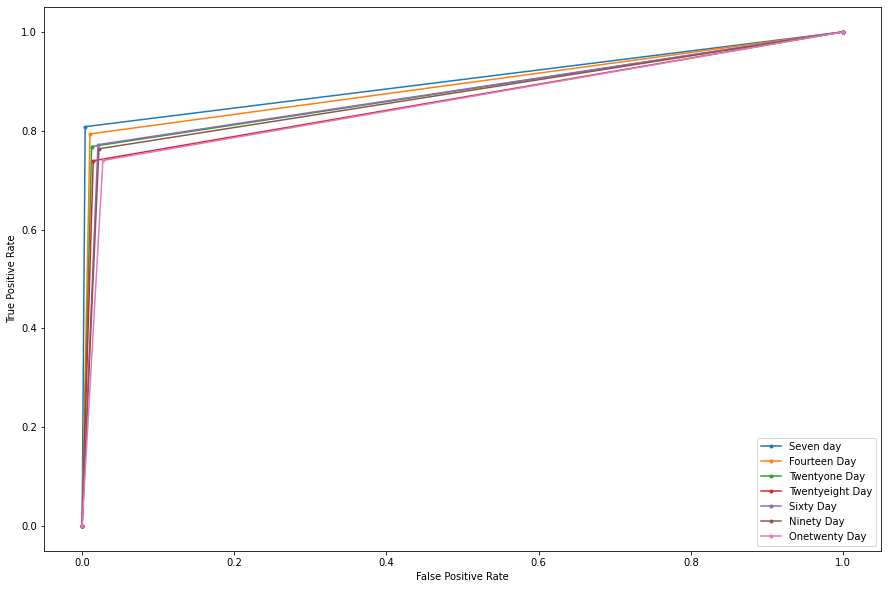

In [33]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,10))

for (pred, test, label) in [
        (y_seven_day_pred, y_seven_day_test, 'Seven day')
        , (y_fourteen_day_pred, y_fourteen_day_test, 'Fourteen Day')
        , (y_twentyone_day_pred, y_twentyone_day_test, 'Twentyone Day')
        , (y_twentyeight_day_pred, y_twentyeight_day_test, 'Twentyeight Day')
        , (y_sixty_day_pred, y_sixty_day_test, 'Sixty Day')
        , (y_ninety_day_pred, y_ninety_day_test, 'Ninety Day')
        , (y_onetwenty_day_pred, y_onetwenty_day_test, 'Onetwenty Day')
    ]:
    fpr, tpr, _ = roc_curve(test, pred)
    plt.plot(fpr, tpr, marker='.', label=label)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


#### PRC curve

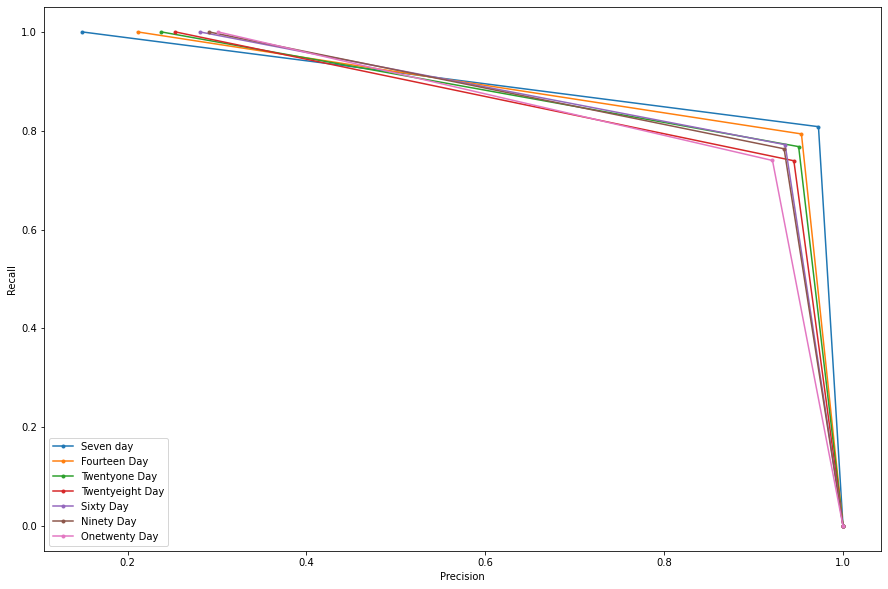

In [34]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(15,10))

for (pred, test, label) in [
        (y_seven_day_pred, y_seven_day_test, 'Seven day')
        , (y_fourteen_day_pred, y_fourteen_day_test, 'Fourteen Day')
        , (y_twentyone_day_pred, y_twentyone_day_test, 'Twentyone Day')
        , (y_twentyeight_day_pred, y_twentyeight_day_test, 'Twentyeight Day')
        , (y_sixty_day_pred, y_sixty_day_test, 'Sixty Day')
        , (y_ninety_day_pred, y_ninety_day_test, 'Ninety Day')
        , (y_onetwenty_day_pred, y_onetwenty_day_test, 'Onetwenty Day')
    ]:
    precision, recall, thresholds = precision_recall_curve(test, pred)
    plt.plot(precision, recall, marker='.', label=label)

# axis labels
plt.xlabel('Precision')
plt.ylabel('Recall')
# show the legend
plt.legend()
# show the plot
plt.show()

### MCC F1

In [35]:
from mcc_f1 import plot_mcc_f1_curve

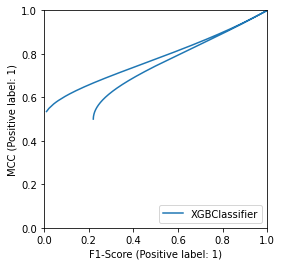

In [36]:
plot_mcc_f1_curve(xgb_seven_day, X_test, y_seven_day_pred)

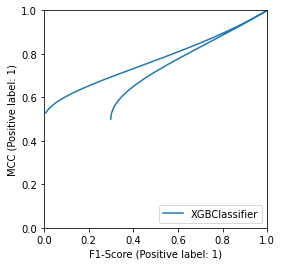

In [37]:
plot_mcc_f1_curve(xgb_fourteen_day, X_test, y_fourteen_day_pred)

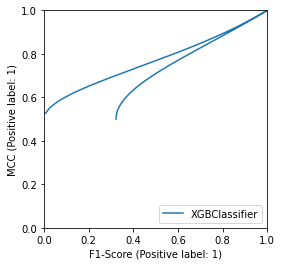

In [38]:
plot_mcc_f1_curve(xgb_twentyone_day, X_test, y_twentyone_day_pred)

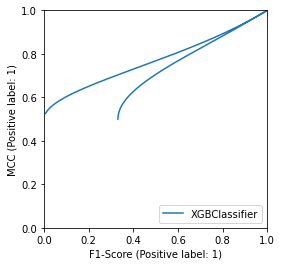

In [39]:
plot_mcc_f1_curve(xgb_twentyeight_day, X_test, y_twentyeight_day_pred)

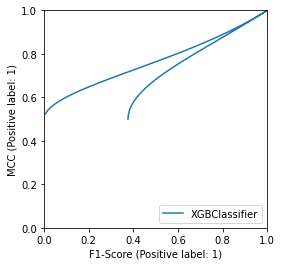

In [40]:
plot_mcc_f1_curve(xgb_sixty_day, X_test, y_sixty_day_pred)

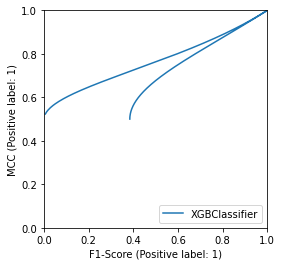

In [41]:
plot_mcc_f1_curve(xgb_ninety_day, X_test, y_ninety_day_pred)

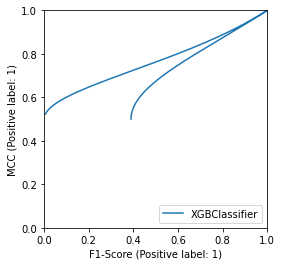

In [42]:
plot_mcc_f1_curve(xgb_onetwenty_day, X_test, y_onetwenty_day_pred)

#### Prediction probability distribution

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


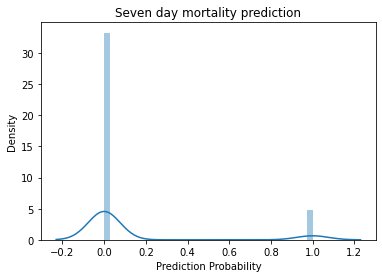

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


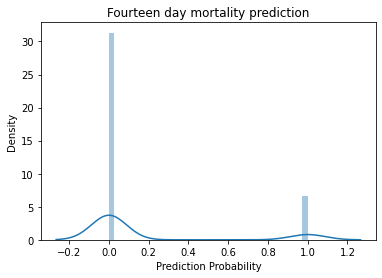

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


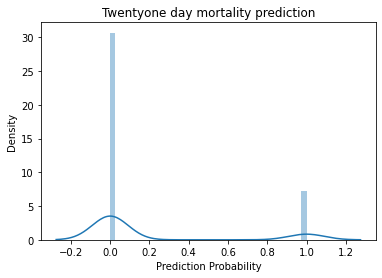

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


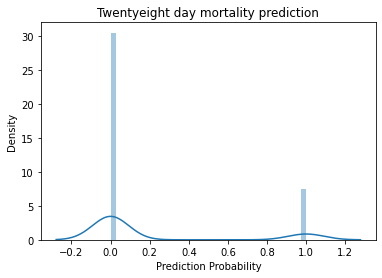

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


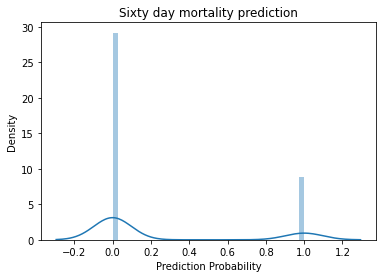

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


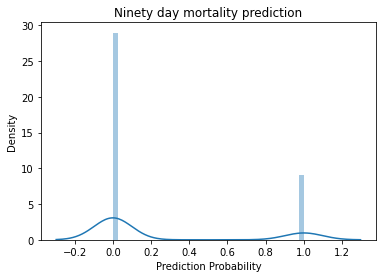

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


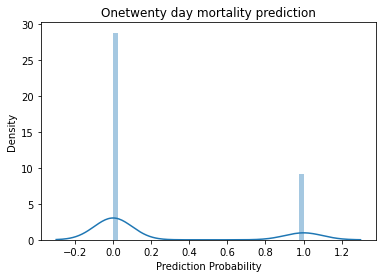

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

for (pred, label) in [
        (y_seven_day_pred, 'Seven day mortality prediction')
        , (y_fourteen_day_pred, 'Fourteen day mortality prediction')
        , (y_twentyone_day_pred, 'Twentyone day mortality prediction')
        , (y_twentyeight_day_pred, 'Twentyeight day mortality prediction')
        , (y_sixty_day_pred, 'Sixty day mortality prediction')
        , (y_ninety_day_pred, 'Ninety day mortality prediction')
        , (y_onetwenty_day_pred, 'Onetwenty day mortality prediction')
    ]:
    sns.distplot(pred, hist=True, rug=False, axlabel='Prediction Probability')
    plt.title(label)
    plt.show()